# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)


In [2]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.34.0.dev0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

In [12]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_path = '/home/ayesha.ishaq/Downloads/val/c/d/a/6/cda65b541c.jpg'
    # raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
    raw_image = Image.open(img_path).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

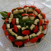

load checkpoint from /home/ayesha.ishaq/Desktop/AI701/CookBookCreater/checkpoint_5.pth
caption:  insalata caprese


In [15]:
from models.blip import blip_decoder

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model_url = "/home/ayesha.ishaq/Desktop/AI701/CookBookCreater/checkpoint_5.pth"
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base', prompt='')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    # caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    caption = model.generate(image, sample=True, top_p=0.98, max_length=8, min_length=1) 
    print('caption: ',caption[0])

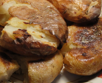

RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 0

In [8]:
image_size = 384
image = load_demo_image(image_size=image_size, device=device)
with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=10, min_length=1) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])